In [3]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

import yace.helpers.evaluation as yace_eval

from yace.run_worker import JobInfo


In [41]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        experiment_id = working_dir.name
        if experiment_id.startswith("2022"):
            experiment_id = experiment_id[0:19]
        else:
            experiment_id = "-".join(experiment_id.split("-")[0:2])
        df_perf_data["experiment_id"] = experiment_id
        df_perf_data["experiment_name"] = working_dir.parent.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["job_info_path"] = job_info_path
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [76]:
job_info_paths = list(Path("../data/experiments-odin/adv/full_adjusted_01/").glob("**/job-info.json"))
# job_info_paths += list(Path("../data/experiments-skadi/adv/full_adjusted_02/").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 600


In [77]:
df_raw_results = get_raw_results(job_info_paths)
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
print(f"Number of results: {df_raw_results.shape[0]}")

Number of results: 72000


In [78]:
df_raw_results.experiment_id.unique()

array(['2022-05-20-05-47-02', 'g71bb7e375eb3483eb840edf7e399ef48-r4',
       'g71bb7e375eb3483eb840edf7e399ef48-r1',
       'g535df71542bd45efa032d24fa2a74349-r4',
       'g71bb7e375eb3483eb840edf7e399ef48-r0',
       'g71bb7e375eb3483eb840edf7e399ef48-r3',
       'g535df71542bd45efa032d24fa2a74349-r2',
       'g535df71542bd45efa032d24fa2a74349-r1',
       'g535df71542bd45efa032d24fa2a74349-r3',
       'g535df71542bd45efa032d24fa2a74349-r0',
       'g71bb7e375eb3483eb840edf7e399ef48-r2'], dtype=object)

In [79]:
grouping_cols = ["experiment_name", "epsilon", "k", "k_formatted", "algorithm_name", "solution_type"]
aggregation_spec = dict(
    n_solutions=("distortion", "count"),
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    input_cost_mean=("input_cost", np.mean),
    input_cost_std= ("input_cost", np.std),
    coreset_cost_mean=("coreset_cost", np.mean),
    coreset_cost_std= ("coreset_cost", np.std),
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
# df_grouped

In [80]:
pd.pivot(
    data=df_grouped,
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="distortion_mean"
)

algorithm_name                              sensitivity-sampling  \
experiment_name  epsilon k   solution_type                         
full_adjusted_01 0.01    10  adv0_33                    1.009835   
                             adv0_50                    1.012112   
                             adv0_50_fixed              1.012559   
                             adv0_67                    1.017702   
                         20  adv0_33                    1.002463   
...                                                          ...   
full_adjusted_02 0.20    70  adv0_67                    1.013718   
                         100 adv0_33                    1.009446   
                             adv0_50                    1.009036   
                             adv0_50_fixed              1.009312   
                             adv0_67                    1.009324   

algorithm_name                              sensitivity-sampling-ex  \
experiment_name  epsilon k   solution_type                            
full_adjusted_01 0.01    10  adv0_33                       1.005479   
                             adv0_50                       1.007341   
                             adv0_50_fixed                 1.006851   
                             adv0_67                       1.009558   
                         20  adv0_33                       1.004721   
...                                                             ...   
full_adjusted_02 0.20    70  adv0_67                       1.017084   
                         100 adv0_33                       1.008851   
                             adv0_50                       1.008829   
                             adv0_50_fixed                 1.008986   
                             adv0_67                       1.008804   

algorithm_name                              uniform-sampling  
experiment_name  epsilon k   solution_type                    
full_adjusted_01 0.01    10  adv0_33                1.005779  
                             adv0_50                1.009552  
                             adv0_50_fixed          1.008839  
                             adv0_67                1.010423  
                         20  adv0_33                1.002093  
...                                                      ...  
full_adjusted_02 0.20    70  adv0_67                1.014886  
                         100 adv0_33                1.005662  
                             adv0_50                1.005915  
                             adv0_50_fixed          1.005797  
                             adv0_67                1.005919  

[120 rows x 3 columns]

In [81]:
colors = sns.color_palette("colorblind")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}

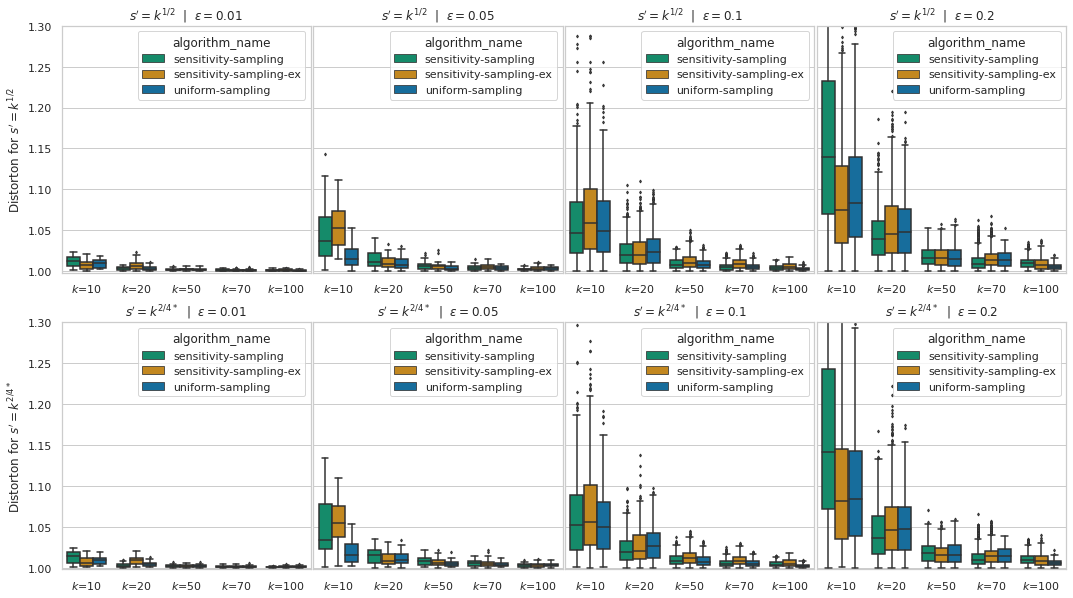

In [83]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
solution_types = ["adv0_50", "adv0_50_fixed"]
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 10))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.boxplot(
            data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", palette=algorithm_colors,
            flierprops=dict(markerfacecolor = '0.50', markersize = 2),
            ax=ax
        )
        ax.set_ylim(bottom=0.998, top=1.3)
        ratio = {"adv0_50_fixed": "2/4*", "adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
fig.savefig(f"plots-boxplot-distortions-instance-2-{df_raw_results.experiment_name.unique()[0]}.pdf", )

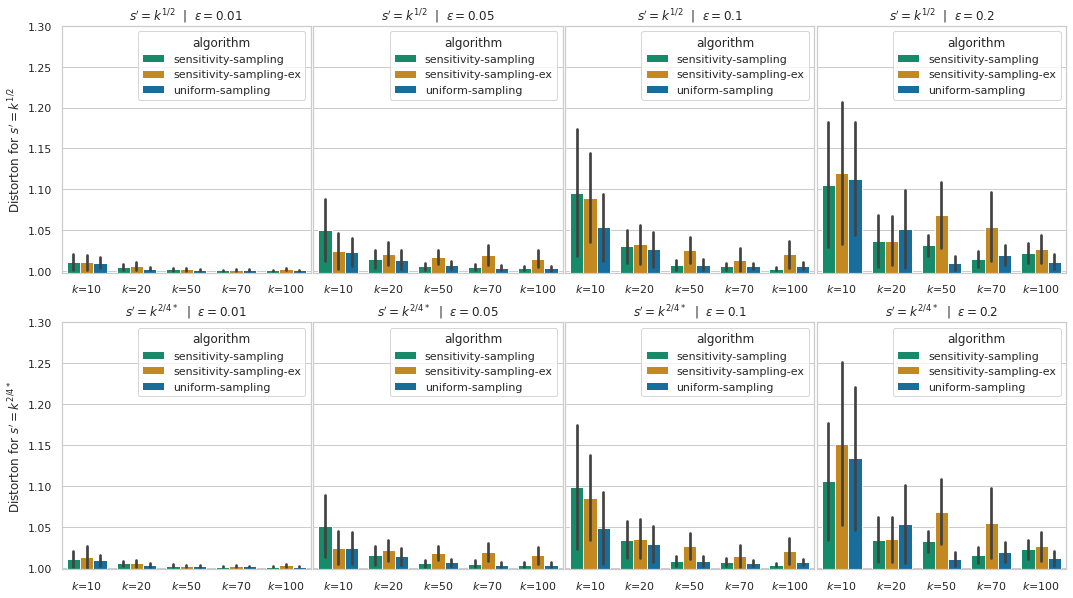

In [53]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
solution_types = ["adv0_50", "adv0_50_fixed"]
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 10))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(
            data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", palette=algorithm_colors, 
            # estimator=np.median, ci=None,
            estimator=np.mean, ci="sd",
            ax=ax
        )
        ax.set_ylim(bottom=0.998, top=1.3)
        ratio = {"adv0_50_fixed": "2/4*", "adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
fig.savefig(f"plots-barplot-distortions-instance-2-{df_raw_results.experiment_name.unique()[0]}.pdf", )

## Costs

In [21]:
pd.pivot(
    data=df_grouped[(df_grouped.solution_type == "adv0_50_fixed") & (df_grouped.epsilon == 0.2)],
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="input_cost_mean"
)

algorithm_name                                sensitivity-sampling  \
experiment_name    epsilon k   solution_type                         
full_unadjusted_01 0.2     10  adv0_50_fixed           3303.063027   
                           20  adv0_50_fixed          12756.304655   
                           50  adv0_50_fixed          72071.881106   
                           70  adv0_50_fixed         136352.975349   
                           100 adv0_50_fixed         266029.220500   

algorithm_name                                sensitivity-sampling-ex  \
experiment_name    epsilon k   solution_type                            
full_unadjusted_01 0.2     10  adv0_50_fixed              3303.063027   
                           20  adv0_50_fixed             12756.304655   
                           50  adv0_50_fixed             72071.881106   
                           70  adv0_50_fixed            136352.975349   
                           100 adv0_50_fixed            266029.220500   

algorithm_name                                uniform-sampling  
experiment_name    epsilon k   solution_type                    
full_unadjusted_01 0.2     10  adv0_50_fixed       3303.063027  
                           20  adv0_50_fixed      12756.304655  
                           50  adv0_50_fixed      72071.881106  
                           70  adv0_50_fixed     136352.975349  
                           100 adv0_50_fixed     266029.220500

In [22]:
pd.pivot(
    data=df_grouped[(df_grouped.solution_type == "adv0_50_fixed") & (df_grouped.epsilon == 0.2)],
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="coreset_cost_mean"
)

algorithm_name                                sensitivity-sampling  \
experiment_name    epsilon k   solution_type                         
full_unadjusted_01 0.2     10  adv0_50_fixed           2923.392850   
                           20  adv0_50_fixed          12268.006296   
                           50  adv0_50_fixed          73665.801827   
                           70  adv0_50_fixed         132890.261860   
                           100 adv0_50_fixed         263166.333372   

algorithm_name                                sensitivity-sampling-ex  \
experiment_name    epsilon k   solution_type                            
full_unadjusted_01 0.2     10  adv0_50_fixed              3495.425456   
                           20  adv0_50_fixed             12249.955640   
                           50  adv0_50_fixed             71323.192459   
                           70  adv0_50_fixed            134231.327404   
                           100 adv0_50_fixed            253957.064542   

algorithm_name                                uniform-sampling  
experiment_name    epsilon k   solution_type                    
full_unadjusted_01 0.2     10  adv0_50_fixed       2767.576541  
                           20  adv0_50_fixed      12632.967052  
                           50  adv0_50_fixed      72271.525695  
                           70  adv0_50_fixed     132286.639447  
                           100 adv0_50_fixed     266609.828188